# Photogrammetry Example

In [1]:
import logging
logging.basicConfig()
logging.getLogger("cedalion").setLevel(logging.DEBUG)

logging.getLogger('trame_client').setLevel(logging.WARNING)

logging.getLogger('trame_server').setLevel(logging.WARNING)

import cedalion.io
import cedalion.plots
from cedalion.geometry.photogrammetry.processors import ColoredStickerProcessor
import xarray as xr
import pyvista as pv

xr.set_options(display_expand_data=False);

import importlib
importlib.reload(cedalion.plots)



INFO:pysnirf2:Library loaded by process 15340


<module 'cedalion.plots' from '/Users/masha/Documents/Uni/AlexLab/cedalion/cedalion/src/cedalion/plots.py'>

## Choose between interactive and static 3D plots

In [2]:
pv.set_jupyter_backend("static")  # uncomment for static rendering
#pv.set_jupyter_backend("client")  # uncomment for interactive rendering

Use `cedalion.io.read_einstar_obj` to read the textured triangle mesh produced by the Einstar scanner.

In [3]:
#s = cedalion.io.read_einstar_obj("../../headmodelling/scan/test0post.obj")
s = cedalion.io.read_einstar_obj("../../../3dscan/headmodelling/scan/cutscan/cutscan.obj")
s = cedalion.io.read_einstar_obj("../../../3dscan/headmodelling/scan/shift4.obj")

Processors are meant to analyze the textured mesh and extract positions. The ColoredStickerProcessor searches for colored circular areas. The colors must be specified by their ranges in hue and value. These can for example be found by usig a color pipette tool on the texture file.

In the following to classes of stickers are searched: "O(ptodes)" in blue and "L(andmarks" in yellow.

In [4]:
processor = ColoredStickerProcessor(
    colors={
        "O" : ((0.11, 0.21, 0.7, 1)), # (hue_min, hue_max, value_min, value_max)
        #"L" : ((0.25, 0.37, 0.35, 0.6))
    }
)

In [5]:
sticker_centers, normals, details = processor.process(s, details=True)

[[ 75.588409  40.123718 452.155945]
 [ 75.1884    40.123718 452.188782]
 [ 74.788406  40.123718 452.215576]
 ...
 [107.649712 112.571342 399.528473]
 [109.057274  77.41523  284.200592]
 [109.057274  77.41523  284.200592]]
[[ 75.588409  40.123718 452.155945]
 [ 75.1884    40.123718 452.188782]
 [ 74.788406  40.123718 452.215576]
 ...
 [162.995621   4.923721 389.31897 ]
 [162.683212   4.523727 389.31897 ]
 [161.991013   3.723724 389.31897 ]]
O (0.11, 0.21, 0.7, 1)
[0.09084368 0.03052839 0.10707354 0.23410139 0.09764936 0.11341352
 0.39883623 0.07840315 0.03647173 0.30065596 0.09160932 0.11272505
 0.06626543 0.08361982 0.05356184 0.09709368 0.03484453 0.09632769
 0.1893062  0.13699812 0.00778669 0.09379839 0.47435198 0.08235491
 0.03245893 0.01833296 0.05088701 0.08386335 0.30185347 0.03686811
 0.11998884 0.15678389 0.20428266 0.08062578 0.00980329 0.03609724
 0.06496416 0.09267927 0.10368147 0.23539385 0.10264997 0.00481428
 0.10959856 0.00981794 0.28458269 0.06140825]
6.115082835321841


/Users/masha/Documents/Uni/AlexLab/cedalion/cedalion/src/cedalion/geometry/photogrammetry/processors.py:356: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  detail_coords = np.array(detail_coords)[sorted_indices]
/Users/masha/Documents/Uni/AlexLab/cedalion/cedalion/src/cedalion/geometry/photogrammetry/processors.py:357: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  detail_colors = np.array(detail_colors)[sorted_indices]


In [6]:
display(sticker_centers)
sticker_centers[0]

Magnitude,[[142.59588476898298 6.568571620341323 418.8786296121232] [112.23926838618087 19.902060719664746 255.31506572101625] [127.19655451073385 5.928837608214078 267.79395237783666] [141.36381419674953 -17.570654557356036 403.91920532609936] [98.11391293393935 80.51432672248986 258.5443930400329] [52.836701615830776 21.59285983848861 244.81348703318372] [119.4895605824585 52.947358545318956 439.0724297317951] [97.58137791576524 60.633526052820585 253.19230368829375] [134.72238432479077 17.872589594905506 429.39152905144516] [78.95162506661194 53.18591261139984 247.4544555522999] [105.63348533027171 -7.02065294448185 435.28629134500267] [112.67992084107223 1.346866635035683 260.0713800451626] [56.162700712975756 68.89831227390002 251.8149386179519] [161.22385334986802 5.2710650318344765 395.40031019684517] [102.3416611881505 -25.739824069378255 274.31747012494014] [96.61639100363115 39.43580677983894 249.5799458828701] [71.83251810631755 7.025518706108268 246.98977683140888] [131.8664125131598 53.5418292073464 266.4287141470766] [114.39061281405287 5.842091440467828 437.44393102978245] [108.25340315611663 61.28955512341952 444.8616635542737] [82.0666021692765 -21.644825347040054 434.5042149442732] [80.10909915036075 38.49497695088318 451.59419584911893] [96.0893822006412 20.057059010514642 248.91464452904106] [124.76338551010409 -4.2643362511283796 427.762587472925] [84.70145972525106 -10.339866986525863 256.0756214660176] [88.19375153372033 5.671522001332386 444.4150852505852] [66.65690383445192 -3.47005230973768 444.66702055562797] [53.304030411307885 53.75562686907269 247.90387330903596] [148.40240390733857 23.649804358045763 420.40951003193567] [150.4910751353695 31.478963610705048 279.3889945930635] [76.70755534427168 29.823584319350246 245.03365363925047] [120.20614891739561 -29.337262143201052 415.41758999104877] [101.62263342548613 45.55364638821206 447.1630255437344] [72.32754686333809 16.755797112901472 449.81121558024256] [85.65327860113237 99.08194743706292 264.3536353057495] [116.49915798726613 27.95075009418824 442.4856840064792] [132.14016265690617 30.590707018503654 264.5407040096815] [74.6732982076009 78.81820118835665 255.21593622908844] [134.85136684330948 35.741193286169235 432.2075109846364] [49.84995185869384 10.200838976392104 448.8786048894638] [99.17536625771906 -34.26341558332977 419.78775343564877] [115.94993046725432 -42.70115066653714 399.47919781743826] [93.57023854044155 21.05995153508086 447.7201490983525] [118.64183800477859 68.41153803589715 262.6537646581167] [36.24103098414839 42.817518204613876 247.01984405883908] [115.1926018456472 49.7200851924242 256.967691555789]]
Units,millimeter


Magnitude,[142.59588476898298 6.568571620341323 418.8786296121232]
Units,millimeter


Visualize the surface and extraced results.

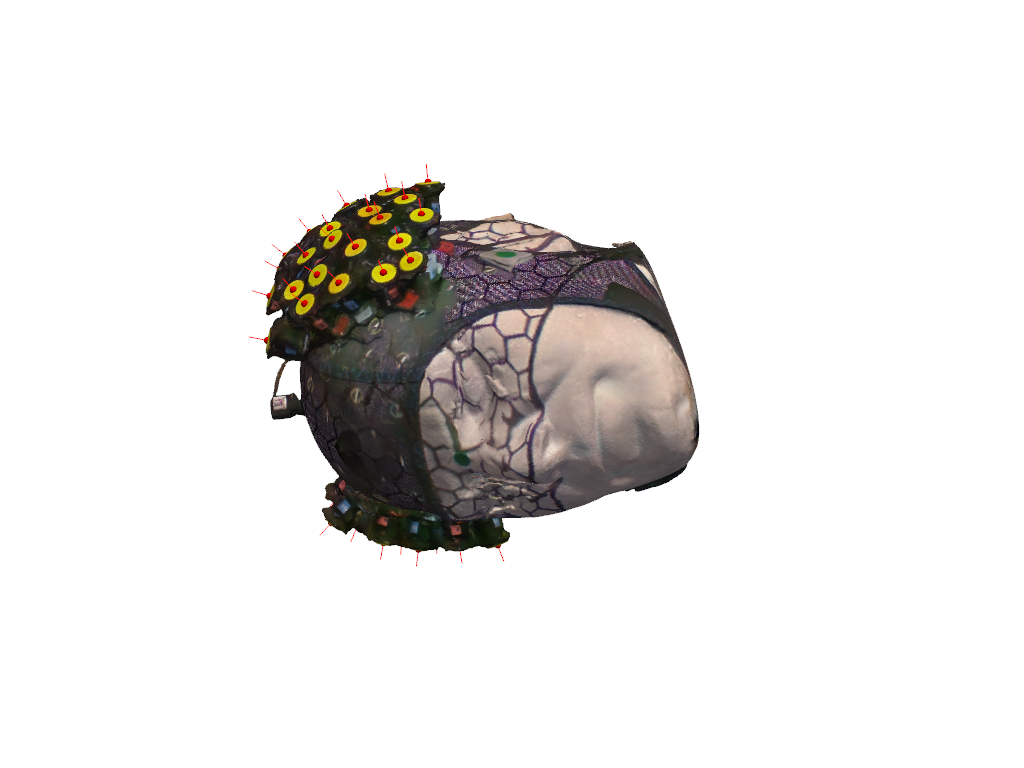

In [7]:
plt = pv.Plotter()
cedalion.plots.plot_surface(plt, s, opacity=1.0)
cedalion.plots.plot_labeled_points(plt, sticker_centers, color="r")
cedalion.plots.plot_vector_field(plt, sticker_centers, normals)
plt.show()

The details object is meant as a container for debuging information. It also provides plotting functionality.The following scatter plot shows the vertex colors in the hue-value plane in which the vertex classification operates.

In [ ]:
details.plot_vertex_colors()

The following plots show for each cluster (tentative group of sticker vertices) The vertex positions perpendicular to the sticker normal as well as the minimum enclosing circle which is used to find the sticker's center.

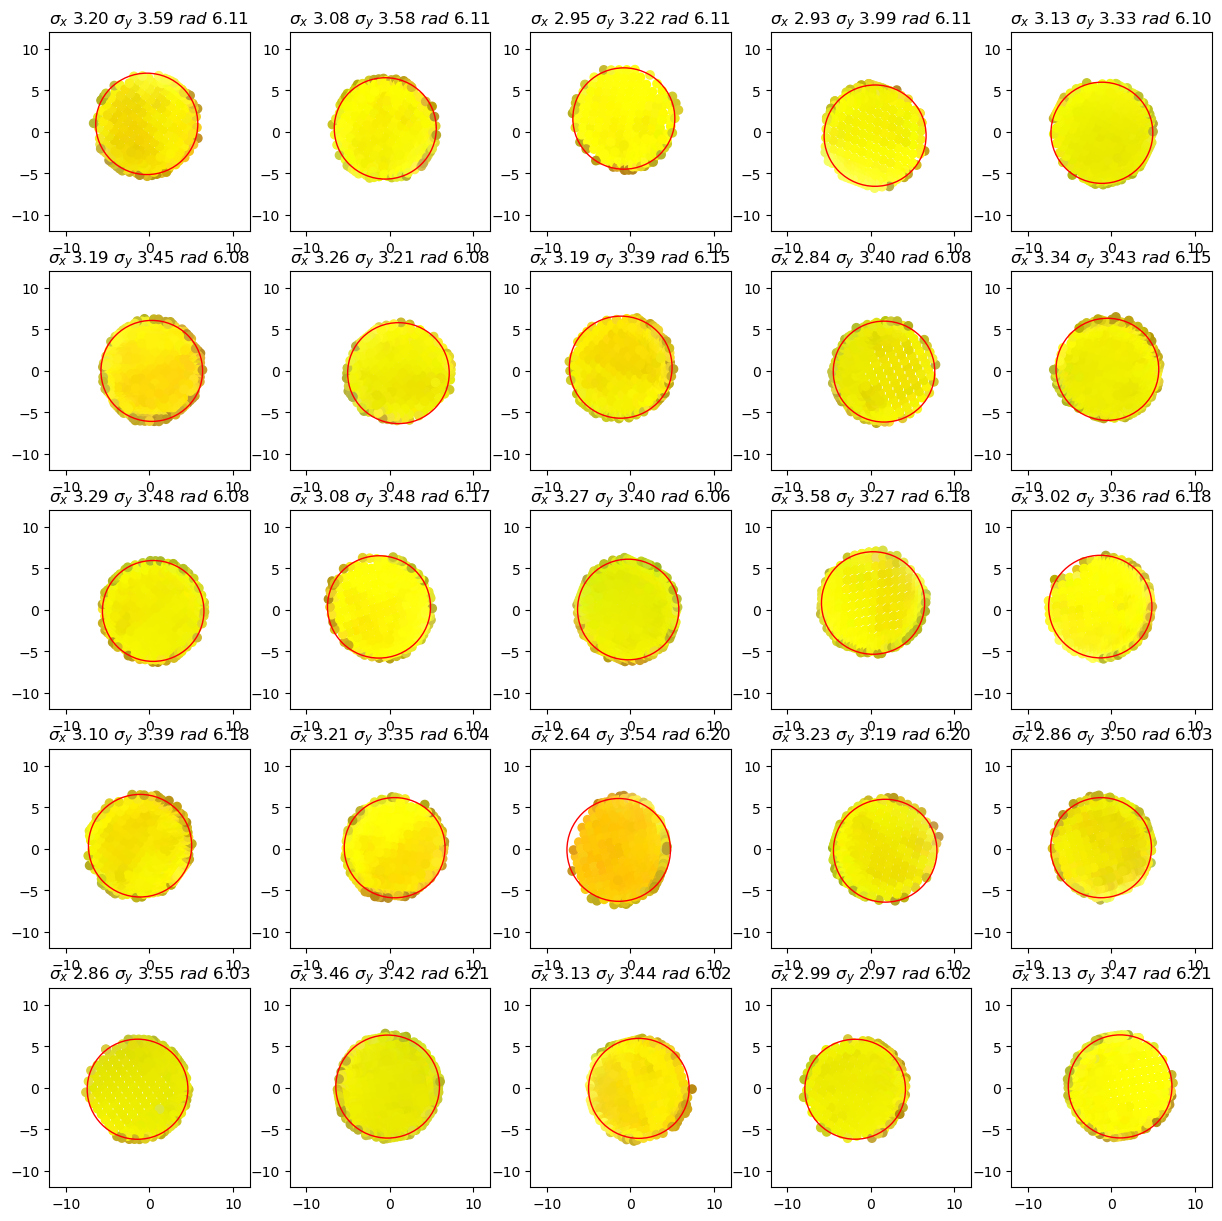

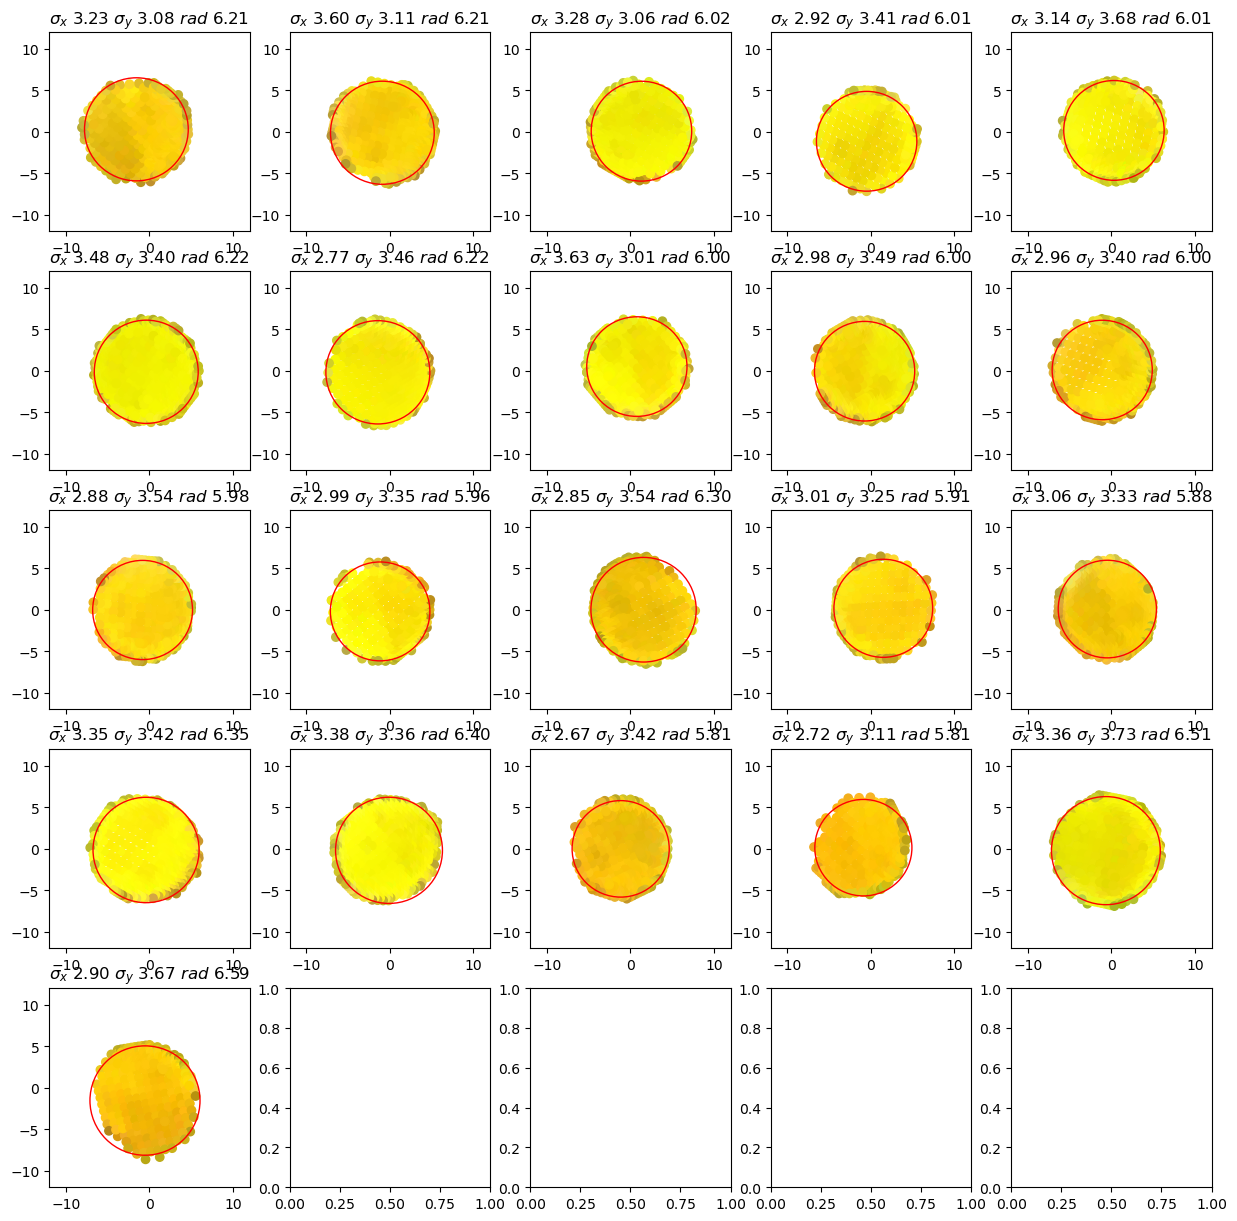

In [9]:
details.plot_cluster_circles()

Finally, to get from the sticker centers to the scalp coordinates we have to subtract the lenght of the optodes in the direction of the normals:

In [10]:
optode_length = 22.6 * cedalion.units.mm

scalp_coords = sticker_centers.copy()
mask_optodes = sticker_centers.group == 'O'
scalp_coords[mask_optodes] = sticker_centers[mask_optodes] - optode_length*normals[mask_optodes]

In [ ]:
display(scalp_coords)

Magnitude,[[131.12284345040592 9.57514104435086 399.6409098095885] [102.51945120006447 23.898788010172666 275.3228473280257] [116.5957654695105 14.26894220309799 285.9275104139716] [125.73059669121147 -3.8518452459860537 395.07857291077937] [95.21819407033209 73.3860252522379 279.7943843438465] [55.58516691129159 23.828447598731394 267.1340624264369] [111.05851936864707 50.25897147851065 418.27699467912] [91.78516935099407 55.78044408604332 274.49046233399395] [119.84141413223149 21.262550761255824 412.72344909546945] [75.8547909752144 50.05254325889533 269.62090802244364] [98.33185819889981 -2.690294962262179 414.3412623170868] [101.66547826468401 6.5859049484843775 279.09753394661266] [60.76829550947137 61.97631400519812 272.8300388208674] [144.99643205210072 19.84289185078584 389.4764042908354] [99.68208396210737 -5.954975251144081 284.9121105727482] [91.40065743573923 36.103950157720554 271.31597253905574] [72.03058722390236 12.978057894966511 268.7908787721312] [121.94166378026443 49.231731798055144 286.27014612441417] [102.62685175269593 12.968161267002383 419.5109152622475] [98.6403511263532 62.6990391563978 424.45669882914274] [79.56423309910252 -8.336617955607222 416.41029980510973] [77.80676449195661 39.192965463639126 429.12261230107384] [87.73226677393998 18.369181242158707 269.84475896694806] [116.09593677125224 4.978850295109063 409.0489872091909] [84.96644119036256 2.807518547560976 274.45593806941787] [85.71244059082466 9.000122072325833 422.1996960446305] [67.21127248667955 3.2394472429774046 423.0930711918804] [59.332396480643034 44.85120098639544 267.78175051546816] [134.70567357902388 27.958168920759825 402.95678608671227] [133.7911797659541 36.43462119206919 293.7874303618144] [74.24766786635605 29.90452162510272 267.49923626576015] [113.22908984157415 -11.537524084009025 403.3656203729055] [95.29747555370449 45.50240000607409 425.4662573119134] [71.88771996238354 21.237786631737674 427.6644703961249] [82.70079009457845 84.85781928229186 281.665971654588] [107.84935151767851 31.98554221658966 422.0000475612113] [119.35166431903707 30.377086958367194 283.1731669905176] [77.55190968696769 66.57646852393391 273.99394403938777] [123.47520575629636 39.64436227052517 413.07355606669296] [54.91722109526824 18.278228616310884 428.3886424910357] [96.81450302910395 -16.36131886126279 406.1972693467897] [108.05490150029155 -22.786916415669538 392.278378988139] [90.20635585270063 26.793163933613403 426.1198118589382] [108.75963542329531 62.57965941578577 282.12403080675506] [39.694314973833684 37.709729516448164 268.7625514432388] [107.58064774833692 44.55402327542256 277.61060702551237]]
Units,millimeter


In [12]:
plt = pv.Plotter()
cedalion.plots.plot_surface(plt, s, opacity=0.3)
cedalion.plots.plot_labeled_points(plt, sticker_centers, color="r")
cedalion.plots.plot_labeled_points(plt, scalp_coords, color="g")
cedalion.plots.plot_vector_field(plt, sticker_centers, normals)
plt.show()

Widget(value='<iframe src="http://localhost:62892/index.html?ui=P_0x1b027fd30_1&reconnect=auto" class="pyvista…

[128.0658485  117.37700765 360.69678168]
[124.85402353 -13.91044905 336.07799994]
[-33.75251448  31.94342743 355.25572848]
[-41.03953478  42.70598267 357.78651803]
[ 54.99792117  75.23864572 432.80490304]
[ 44.27594186 101.35637596 289.00650707]


INFO:aiohttp.access:127.0.0.1 [12/Mar/2024:17:48:48 +0100] "GET /index.html?ui=P_0x1b6667760_3&reconnect=auto HTTP/1.1" 200 236 "http://localhost:8888/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36"
INFO:aiohttp.access:127.0.0.1 [12/Mar/2024:17:48:48 +0100] "POST /paraview/ HTTP/1.1" 405 208 "http://localhost:62892/index.html?ui=P_0x1b6667760_3&reconnect=auto" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36"
INFO:wslink.backends.aiohttp:client e4827eb808c64d02b15fcece333a9ce9 connected
INFO:aiohttp.access:127.0.0.1 [12/Mar/2024:17:48:51 +0100] "GET /index.html?ui=P_0x1b6665ff0_4&reconnect=auto HTTP/1.1" 200 236 "http://localhost:8888/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36"
INFO:aiohttp.access:127.0.0.1 [12/Mar/2024:17:48:51 +0100] "POST /paraview/ HTTP/1.1" 405 2

**TBD: The found landmark and optode positions must still be matched to a montage in order to distinguish between sources and detectors and to assign the correct labels.**

Select landmarks 

(temporaly being stored in *landmark_points*)

In [13]:
landmark_points = []
plt = pv.Plotter()
cedalion.plots.plot_surface(plt, s, opacity=1.0, ppoints = landmark_points)
plt.show()

Widget(value='<iframe src="http://localhost:62892/index.html?ui=P_0x1b65e0f40_2&reconnect=auto" class="pyvista…

In [15]:
landmark_points

[[128.06584850285756, 117.3770076471535, 360.6967816792006],
 [124.85402353405117, -13.910449048161297, 336.07799994301587],
 [-33.75251447879049, 31.94342742733818, 355.2557284752894],
 [-41.039534782707705, 42.7059826720392, 357.7865180295447],
 [54.99792117172921, 75.23864571559129, 432.80490303585606],
 [44.27594185673034, 101.3563759601127, 289.0065070733808]]

Function orderReferencePoints6 to assign labels to landmarks

In [16]:
def orderReferencePoints6(landmarks, twoPoints):
    # Validate input parameters
    if len(landmarks.label) != 6 or twoPoints not in ["Nz", "Iz"]:
        raise ValueError("Invalid input parameters")
    
    outReference = landmarks.values  # Extract the numerical values for computation
    
    # Compute pairwise distances efficiently
    distances = np.linalg.norm(outReference[:, np.newaxis, :] - outReference[np.newaxis, :, :], axis=2)
    np.fill_diagonal(distances, np.inf)  # Ignore self-distances by setting them to infinity
    
    # Find two closest points
    close1, close2 = np.unravel_index(np.argmin(distances), distances.shape)
    
    # Reset distances for closest points to find the opposite
    distances[range(len(outReference)), range(len(outReference))] = 0
    opposite = np.argmax(distances[close1])
    
    # Determine Cz as the point closest to the plane defined by close1, close2, and opposite
    v1, v2 = outReference[close1] - outReference[opposite], outReference[close2] - outReference[opposite]
    cp = np.cross(v1, v2)
    d = np.dot(cp, outReference[close1])
    plane_distances = np.abs(np.dot(outReference, cp) - d) / np.linalg.norm(cp)
    plane_distances[[close1, close2, opposite]] = np.inf
    Cz = np.argmin(plane_distances)
    
    # Determine Nz and Iz based on the given 'twoPoints' label
    Nz, Iz = (close1, opposite) if twoPoints == "Nz" else (opposite, close1)
    
    # Determine Rpa and Lpa
    remaining = set(range(6)) - {close1, close2, opposite, Cz}
    cr = np.cross(outReference[Nz] - outReference[Cz], outReference[Iz] - outReference[Cz])
    cr /= np.linalg.norm(cr)
    sorted_remaining = sorted(remaining, key=lambda x: np.dot(cr, outReference[x] - outReference[Cz]))
    Rpa, Lpa = sorted_remaining[0], sorted_remaining[1]  # Assuming the first is Lpa and the second is Rpa based on sorting

    # Creating the ordered DataArray for output
    ordered_indices = [Nz, Iz, Rpa, Lpa, Cz]
    ordered_landmarks = landmarks.isel(label=ordered_indices)
    
    # Updating labels to reflect the new order
    new_labels = ["Nz", "Iz", "RPA", "LPA", "Cz"]
    ordered_landmarks["label"] = new_labels
    
    return ordered_landmarks

In [17]:
import cedalion.dataclasses as cdc
import numpy as np

landmark_pick = landmark_points

labels = ["_"]*6
types = [cdc.PointType.LANDMARK]*6
groups = ["L"]*6
landmarks = xr.DataArray(
    np.vstack(landmark_pick),
    dims=["label", "digitized"],
    coords={
        "label": ("label", labels),
        "type": ("label", types),
        "group": ("label", groups),
    },
).pint.quantify("mm")

display(landmarks)


Magnitude,[[128.06584850285756 117.3770076471535 360.6967816792006] [124.85402353405117 -13.910449048161297 336.07799994301587] [-33.75251447879049 31.94342742733818 355.2557284752894] [-41.039534782707705 42.7059826720392 357.7865180295447] [54.99792117172921 75.23864571559129 432.80490303585606] [44.27594185673034 101.3563759601127 289.0065070733808]]
Units,millimeter


In [18]:
land = orderReferencePoints6(landmarks, "Iz")
display(land)

/usr/local/Caskroom/miniforge/base/envs/cedalion/lib/python3.10/site-packages/xarray/core/variable.py:309: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Magnitude,[[128.06584850285756 117.3770076471535 360.6967816792006] [-33.75251447879049 31.94342742733818 355.2557284752894] [44.27594185673034 101.3563759601127 289.0065070733808] [54.99792117172921 75.23864571559129 432.80490303585606] [124.85402353405117 -13.910449048161297 336.07799994301587]]
Units,millimeter


Load the montage information


In [19]:
import cedalion.geometry.registration
importlib.reload(cedalion.geometry.registration)

elements = cedalion.io.read_snirf("../2024-02-05_013.snirf")
montage_elements = elements[0].geo3d
#geo3d_meas = geo3d_meas.points.rename({"NASION" : "Nz"})
montage_elements = montage_elements.rename({"pos" : "aligned"})
montage_elements

INFO:root:Loading from file ../2024-02-05_013.snirf
INFO:root:IndexedGroup MeasurementList at /nirs/data1 in ../2024-02-05_013.snirf initalized with 200 instances of <class 'snirf.pysnirf2.MeasurementListElement'>
INFO:root:IndexedGroup Data at /nirs in ../2024-02-05_013.snirf initalized with 1 instances of <class 'snirf.pysnirf2.DataElement'>
INFO:root:IndexedGroup Stim at /nirs in ../2024-02-05_013.snirf initalized with 5 instances of <class 'snirf.pysnirf2.StimElement'>
INFO:root:IndexedGroup Aux at /nirs in ../2024-02-05_013.snirf initalized with 17 instances of <class 'snirf.pysnirf2.AuxElement'>
INFO:root:IndexedGroup Nirs at / in ../2024-02-05_013.snirf initalized with 1 instances of <class 'snirf.pysnirf2.NirsElement'>
INFO:root:Closing Snirf file ../2024-02-05_013.snirf


Magnitude,[[-77.817871 15.680613999999998 23.172269999999997] [-61.906841 21.227732000000003 56.492802] [-85.37146 -16.079958 8.900885] ... [77.521 28.883 -39.113] [80.59 14.229 -38.278] [81.95 -0.678 -37.027]]
Units,millimeter


Just a visualization of landmark labels

In [20]:
plt = pv.Plotter()
cedalion.plots.plot3d(None, s.mesh, land, None, labels = land.label.values, plotter = plt) 
plt.show()

Widget(value='<iframe src="http://localhost:62892/index.html?ui=P_0x1b6667760_3&reconnect=auto" class="pyvista…

Find a transformation to align landmarks

In [21]:
trafo = cedalion.geometry.registration.register_trans_rot(land, montage_elements)


In [22]:
filtered_montage_elements = montage_elements.where((montage_elements.type == cdc.PointType.SOURCE) | (montage_elements.type == cdc.PointType.DETECTOR), drop=True)
filtered_montage_elements_t = filtered_montage_elements.points.apply_transform(trafo)
plt = pv.Plotter()
cedalion.plots.plot3d(None, s.mesh, filtered_montage_elements_t, None, plotter = plt) 
plt.show()


Widget(value='<iframe src="http://localhost:62892/index.html?ui=P_0x1b6665ff0_4&reconnect=auto" class="pyvista…

ICP algorithm

In [41]:
transformed_opt_centers, transformation_params, idx = icp_with_full_transform(scalp_coords, 
                                                                            filtered_montage_elements_t, max_iterations = 200) 

distances [ 6.93467293  8.80428423  9.76266554 10.14145995  7.72512598  8.39223915
 13.63329502  8.48757591  8.94730028  7.1291941   7.50524543  6.63667715
 16.27208018 22.75246169 12.16976831  9.18255622  8.42471917 17.27752405
  8.07853076 21.20779978  9.07114937 16.41165341  6.54671252  8.14990986
  8.41935549  9.00004881  9.91129141 12.19494692 19.51982889 19.12953938
  9.67112485  7.7208724  11.58156222 11.37459857 21.69673931  9.19588508
  9.93193453 18.70659855 18.11209799 12.83281093 11.30183635 10.12267045
  9.65951474 13.73408847  6.2809183  11.43251499]
Update if improvement
distances [ 4.28755092  7.07823227  6.06986877  4.81436911  5.87036605 10.35901171
 10.05452293  7.4313834   5.81038534 10.61282647  2.54942484  1.4570607
  7.14860367 15.40018911  9.09962577  7.80328671  6.79712826 10.25882786
  6.48579106  9.79530024  3.67612091  8.81334477  4.58793294  3.07004978
  2.99212457  5.20524084  7.92738375  8.60711124 12.51547039 11.65218429
  8.79973697  2.99268132  9.30414

Extract labels for detected optodes

In [42]:
label_dict = {}
for i, label in enumerate(filtered_montage_elements.coords['label'].values):
    label_dict[i] = label
labels = [label_dict[index] for index in idx]

#reference_labels = [None] * len(filtered_data.coords['label'].values)  # Placeholder for the actual size of reference_points
# Use the indices from the ICP query to assign labels
#for target_idx, ref_idx in enumerate(l):
    # The target_idx is the index in target_points, which maps to the actual label in 'lab'
#    if target_idx in lab:
        # Assign the label from target_points (filtered_data) to the matched reference_point
#        reference_labels[ref_idx] = lab[target_idx]
#print(reference_labels)

plt = pv.Plotter()
cedalion.plots.plot3d(None, s.mesh, None, None, labels = None, plotter = plt) 
cedalion.plots.plot_labeled_points(plt, scalp_coords, color="green", labels = labels)
plt.show()

Widget(value='<iframe src="http://localhost:62892/index.html?ui=P_0x1c3801c00_8&reconnect=auto" class="pyvista…

#### If labels are wrong

Find 3 spread points

And make user select the points in correct order

In [43]:
def find_spread_points(points_xr):
    
    points = points_xr.values
    if len(points) < 3:
        return list(range(len(points)))  # Not enough points to select from

    # Construct KDTree from points
    tree = KDTree(points)
    
    # Step 1: Select the initial point (e.g., the first point)
    initial_point_index = 0
    initial_point = points[initial_point_index]

    # Step 2: Find the farthest point from the initial point
    distances, _ = tree.query(initial_point, k=len(points))
    farthest_point_index = np.argmax(distances)

    # Step 3: Find the "middle-distanced" point from the initial point
    sorted_distances_indices = np.argsort(distances)
    median_index = sorted_distances_indices[len(sorted_distances_indices) // 2]
    middle_distanced_point_index = median_index if median_index != initial_point_index else sorted_distances_indices[len(sorted_distances_indices) // 2 + 1]
    return points_xr.label.isel(label=[initial_point_index, farthest_point_index, middle_distanced_point_index]).values


spread_point_labels = find_spread_points(filtered_montage_elements)
print("Select those points")
print(spread_point_labels)

points = []
plt = pv.Plotter()
cedalion.plots.plot_surface(plt, s, opacity=1.0)
cedalion.plots.plot_labeled_points(plt, sticker_centers, color="r", ppoints = points)
#cedalion.plots.plot_vector_field(plt, sticker_centers, normals)
plt.show()

/usr/local/Caskroom/miniforge/base/envs/cedalion/lib/python3.10/site-packages/xarray/core/variable.py:309: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Select those points
['S1' 'D32' 'D10']


Widget(value='<iframe src="http://localhost:62892/index.html?ui=P_0x1c3bb15d0_9&reconnect=auto" class="pyvista…

In [44]:
labeled_points = points
labeled_points

[6, 14, 33]

Write the selected labels to the corresponding points

In [45]:
new_labels = scalp_coords.label.values.copy()
for i,idx in enumerate(labeled_points): 
    new_labels[idx] = spread_point_labels[i]
scalp_coords = scalp_coords.assign_coords(label=new_labels)
scalp_coords

Magnitude,[[131.12284345040592 9.57514104435086 399.6409098095885] [102.51945120006447 23.898788010172666 275.3228473280257] [116.5957654695105 14.26894220309799 285.9275104139716] [125.73059669121147 -3.8518452459860537 395.07857291077937] [95.21819407033209 73.3860252522379 279.7943843438465] [55.58516691129159 23.828447598731394 267.1340624264369] [111.05851936864707 50.25897147851065 418.27699467912] [91.78516935099407 55.78044408604332 274.49046233399395] [119.84141413223149 21.262550761255824 412.72344909546945] [75.8547909752144 50.05254325889533 269.62090802244364] [98.33185819889981 -2.690294962262179 414.3412623170868] [101.66547826468401 6.5859049484843775 279.09753394661266] [60.76829550947137 61.97631400519812 272.8300388208674] [144.99643205210072 19.84289185078584 389.4764042908354] [99.68208396210737 -5.954975251144081 284.9121105727482] [91.40065743573923 36.103950157720554 271.31597253905574] [72.03058722390236 12.978057894966511 268.7908787721312] [121.94166378026443 49.231731798055144 286.27014612441417] [102.62685175269593 12.968161267002383 419.5109152622475] [98.6403511263532 62.6990391563978 424.45669882914274] [79.56423309910252 -8.336617955607222 416.41029980510973] [77.80676449195661 39.192965463639126 429.12261230107384] [87.73226677393998 18.369181242158707 269.84475896694806] [116.09593677125224 4.978850295109063 409.0489872091909] [84.96644119036256 2.807518547560976 274.45593806941787] [85.71244059082466 9.000122072325833 422.1996960446305] [67.21127248667955 3.2394472429774046 423.0930711918804] [59.332396480643034 44.85120098639544 267.78175051546816] [134.70567357902388 27.958168920759825 402.95678608671227] [133.7911797659541 36.43462119206919 293.7874303618144] [74.24766786635605 29.90452162510272 267.49923626576015] [113.22908984157415 -11.537524084009025 403.3656203729055] [95.29747555370449 45.50240000607409 425.4662573119134] [71.88771996238354 21.237786631737674 427.6644703961249] [82.70079009457845 84.85781928229186 281.665971654588] [107.84935151767851 31.98554221658966 422.0000475612113] [119.35166431903707 30.377086958367194 283.1731669905176] [77.55190968696769 66.57646852393391 273.99394403938777] [123.47520575629636 39.64436227052517 413.07355606669296] [54.91722109526824 18.278228616310884 428.3886424910357] [96.81450302910395 -16.36131886126279 406.1972693467897] [108.05490150029155 -22.786916415669538 392.278378988139] [90.20635585270063 26.793163933613403 426.1198118589382] [108.75963542329531 62.57965941578577 282.12403080675506] [39.694314973833684 37.709729516448164 268.7625514432388] [107.58064774833692 44.55402327542256 277.61060702551237]]
Units,millimeter


Find the affine transformation for the newly labeled points

In [46]:
trafo2 = cedalion.geometry.registration.register_trans_rot(scalp_coords, montage_elements)
filtered_montage_elements = montage_elements.where((montage_elements.type == cdc.PointType.SOURCE) | (montage_elements.type == cdc.PointType.DETECTOR), drop=True)
filtered_montage_elements_t = filtered_montage_elements.points.apply_transform(trafo2)

And run ICP algorithms

In [47]:
transformed_opt_centers, transformation_params, idx = icp_with_full_transform(scalp_coords, 
                                                                            filtered_montage_elements_t, max_iterations = 200) 

distances [ 6.05921357 11.23100464  6.13266672  5.69844859 13.96265782 11.20539316
  4.88768569 13.66530383  3.66744823 12.93570086  3.40874758  7.50241161
 15.23591921  5.62681792  4.94317321 12.03995316  9.20701413  9.97647127
  4.78488895  4.26803188  3.164087    1.87244901 10.34259453  4.00176572
  6.93111955  2.39045327  2.89699838 11.27506815  5.56915678  8.2179027
 11.9709194   6.40232746  2.35461219  0.95377291 14.42779166  2.3890182
  8.54193998 14.00731117  2.89551424  3.65163035  5.40434428  8.81584299
  2.75873966 12.20310926 11.94673641  9.46199127]
Update if improvement
distances [4.85263974 5.26309229 3.62230184 4.22399878 4.23702528 3.05743393
 5.35957116 3.94979279 2.13894599 2.38815001 2.32325052 2.09684669
 3.99877672 4.6362403  7.18578821 2.05816408 2.45526425 2.23308479
 3.63921483 4.25463733 1.683711   3.08579452 1.84924887 2.48444166
 3.26992073 3.01633768 1.89116995 0.69037307 3.96548957 3.80983096
 2.30256169 4.87890312 3.22463579 2.15466627 4.24576684 0.980734

In [48]:
label_dict = {}
for i, label in enumerate(filtered_montage_elements.coords['label'].values):
    label_dict[i] = label
labels = [label_dict[index] for index in idx]

scalp_coords = scalp_coords.assign_coords(label=labels)

plt = pv.Plotter()
cedalion.plots.plot3d(None, s.mesh, None, None, labels = None, plotter = plt) 
cedalion.plots.plot_labeled_points(plt, scalp_coords, color="green", labels = labels)
plt.show()

display(scalp_coords)

Widget(value='<iframe src="http://localhost:62892/index.html?ui=P_0x1bf96f520_10&reconnect=auto" class="pyvist…

Magnitude,[[131.12284345040592 9.57514104435086 399.6409098095885] [102.51945120006447 23.898788010172666 275.3228473280257] [116.5957654695105 14.26894220309799 285.9275104139716] [125.73059669121147 -3.8518452459860537 395.07857291077937] [95.21819407033209 73.3860252522379 279.7943843438465] [55.58516691129159 23.828447598731394 267.1340624264369] [111.05851936864707 50.25897147851065 418.27699467912] [91.78516935099407 55.78044408604332 274.49046233399395] [119.84141413223149 21.262550761255824 412.72344909546945] [75.8547909752144 50.05254325889533 269.62090802244364] [98.33185819889981 -2.690294962262179 414.3412623170868] [101.66547826468401 6.5859049484843775 279.09753394661266] [60.76829550947137 61.97631400519812 272.8300388208674] [144.99643205210072 19.84289185078584 389.4764042908354] [99.68208396210737 -5.954975251144081 284.9121105727482] [91.40065743573923 36.103950157720554 271.31597253905574] [72.03058722390236 12.978057894966511 268.7908787721312] [121.94166378026443 49.231731798055144 286.27014612441417] [102.62685175269593 12.968161267002383 419.5109152622475] [98.6403511263532 62.6990391563978 424.45669882914274] [79.56423309910252 -8.336617955607222 416.41029980510973] [77.80676449195661 39.192965463639126 429.12261230107384] [87.73226677393998 18.369181242158707 269.84475896694806] [116.09593677125224 4.978850295109063 409.0489872091909] [84.96644119036256 2.807518547560976 274.45593806941787] [85.71244059082466 9.000122072325833 422.1996960446305] [67.21127248667955 3.2394472429774046 423.0930711918804] [59.332396480643034 44.85120098639544 267.78175051546816] [134.70567357902388 27.958168920759825 402.95678608671227] [133.7911797659541 36.43462119206919 293.7874303618144] [74.24766786635605 29.90452162510272 267.49923626576015] [113.22908984157415 -11.537524084009025 403.3656203729055] [95.29747555370449 45.50240000607409 425.4662573119134] [71.88771996238354 21.237786631737674 427.6644703961249] [82.70079009457845 84.85781928229186 281.665971654588] [107.84935151767851 31.98554221658966 422.0000475612113] [119.35166431903707 30.377086958367194 283.1731669905176] [77.55190968696769 66.57646852393391 273.99394403938777] [123.47520575629636 39.64436227052517 413.07355606669296] [54.91722109526824 18.278228616310884 428.3886424910357] [96.81450302910395 -16.36131886126279 406.1972693467897] [108.05490150029155 -22.786916415669538 392.278378988139] [90.20635585270063 26.793163933613403 426.1198118589382] [108.75963542329531 62.57965941578577 282.12403080675506] [39.694314973833684 37.709729516448164 268.7625514432388] [107.58064774833692 44.55402327542256 277.61060702551237]]
Units,millimeter


# Playground

In [ ]:
#from snirf import Snirf
#snirf = Snirf("../2024-02-05_013.snirf", 'r+')
#snirf.nirs[0].aux[3].dataUnit = 'deg/s'
#snirf.nirs[0].aux[4].dataUnit = 'deg/s'
#snirf.nirs[0].aux[5].dataUnit = 'deg/s'

#snirf.nirs[0].aux[11].dataUnit = 'ohm'
#snirf.nirs[0].aux[12].dataUnit = '' #ADU
#snirf.nirs[0].aux[16].dataUnit = 'degC' #oC
#snirf.save()

In [24]:
def orderReferencePoints6(landmarks, twoPoints):
    # Validate input parameters
    if len(landmarks.label) != 6 or twoPoints not in ["Nz", "Iz"]:
        raise ValueError("Invalid input parameters")
    
    outReference = landmarks.values  # Extract the numerical values for computation
    
    # Compute pairwise distances efficiently
    distances = np.linalg.norm(outReference[:, np.newaxis, :] - outReference[np.newaxis, :, :], axis=2)
    np.fill_diagonal(distances, np.inf)  # Ignore self-distances by setting them to infinity
    
    # Find two closest points
    close1, close2 = np.unravel_index(np.argmin(distances), distances.shape)
    print("close1,2", close1, close2)
    
    # Reset distances for closest points to find the opposite
    distances[range(len(outReference)), range(len(outReference))] = 0
    opposite = np.argmax(distances[close1])
    
    # Determine Cz as the point closest to the plane defined by close1, close2, and opposite
    v1, v2 = outReference[close1] - outReference[opposite], outReference[close2] - outReference[opposite]
    cp = np.cross(v1, v2)
    d = np.dot(cp, outReference[close1])
    plane_distances = np.abs(np.dot(outReference, cp) - d) / np.linalg.norm(cp)
    plane_distances[[close1, close2, opposite]] = np.inf
    Cz = np.argmin(plane_distances)
    
    # Determine Nz and Iz based on the given 'twoPoints' label
    Nz, Iz = (close1, opposite) if twoPoints == "Nz" else (opposite, close1)
    
    # Determine Rpa and Lpa
    remaining = set(range(6)) - {close1, close2, opposite, Cz}
    cr = np.cross(outReference[Nz] - outReference[Cz], outReference[Iz] - outReference[Cz])
    cr /= np.linalg.norm(cr)
    sorted_remaining = sorted(remaining, key=lambda x: np.dot(cr, outReference[x] - outReference[Cz]))
    Rpa, Lpa = sorted_remaining[0], sorted_remaining[1]  # Assuming the first is Lpa and the second is Rpa based on sorting

    # Creating the ordered DataArray for output
    ordered_indices = [Nz, Iz, Rpa, Lpa, Cz]
    print("ordered_indices", ordered_indices)
    ordered_landmarks = landmarks.isel(label=ordered_indices)
    
    # Updating labels to reflect the new order
    new_labels = ["Nz", "Iz", "RPA", "LPA", "Cz"]
    ordered_landmarks["label"] = new_labels
    
    return ordered_landmarks

In [25]:
import cedalion.dataclasses as cdc
import numpy as np

landmark_pick = points

labels = ["_"]*6
types = [cdc.PointType.LANDMARK]*6
groups = ["L"]*6
landmarks = xr.DataArray(
    np.vstack(landmark_pick),
    dims=["label", "digitized"],
    coords={
        "label": ("label", labels),
        "type": ("label", types),
        "group": ("label", groups),
    },
).pint.quantify("mm")

landmarks

NameError: name 'points' is not defined

In [26]:
land = orderReferencePoints6(landmarks, "Iz")
display(land)


close1,2 2 3
ordered_indices [0, 2, 5, 4, 1]


/usr/local/Caskroom/miniforge/base/envs/cedalion/lib/python3.10/site-packages/xarray/core/variable.py:309: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Magnitude,[[128.06584850285756 117.3770076471535 360.6967816792006] [-33.75251447879049 31.94342742733818 355.2557284752894] [44.27594185673034 101.3563759601127 289.0065070733808] [54.99792117172921 75.23864571559129 432.80490303585606] [124.85402353405117 -13.910449048161297 336.07799994301587]]
Units,millimeter


In [27]:
import cedalion.geometry.registration
importlib.reload(cedalion.geometry.registration)

elements = cedalion.io.read_snirf("../2024-02-05_013.snirf")
geo3d_meas = elements[0].geo3d
#geo3d_meas = geo3d_meas.points.rename({"NASION" : "Nz"})
geo3d_meas = geo3d_meas.rename({"pos" : "aligned"})
geo3d_meas

INFO:root:Loading from file ../2024-02-05_013.snirf
INFO:root:IndexedGroup MeasurementList at /nirs/data1 in ../2024-02-05_013.snirf initalized with 200 instances of <class 'snirf.pysnirf2.MeasurementListElement'>
INFO:root:IndexedGroup Data at /nirs in ../2024-02-05_013.snirf initalized with 1 instances of <class 'snirf.pysnirf2.DataElement'>
INFO:root:IndexedGroup Stim at /nirs in ../2024-02-05_013.snirf initalized with 5 instances of <class 'snirf.pysnirf2.StimElement'>
INFO:root:IndexedGroup Aux at /nirs in ../2024-02-05_013.snirf initalized with 17 instances of <class 'snirf.pysnirf2.AuxElement'>
INFO:root:IndexedGroup Nirs at / in ../2024-02-05_013.snirf initalized with 1 instances of <class 'snirf.pysnirf2.NirsElement'>
INFO:root:Closing Snirf file ../2024-02-05_013.snirf


Magnitude,[[-77.817871 15.680613999999998 23.172269999999997] [-61.906841 21.227732000000003 56.492802] [-85.37146 -16.079958 8.900885] ... [77.521 28.883 -39.113] [80.59 14.229 -38.278] [81.95 -0.678 -37.027]]
Units,millimeter


In [28]:
cedalion.plots.plot3d(None, s.mesh, land, None, labels = land.label.values) 

In [29]:
trafo = cedalion.geometry.registration.register_trans_rot(land, geo3d_meas)
display(trafo)

Magnitude,[[-0.0743037820117224 0.8888350606897947 0.45216278359383305 85.36734967012066] [0.18460315125863347 0.4578393215265788 -0.8696578822786948 54.60744146035007] [-0.9800003186347117 0.01885180502368484 -0.19810094629560063 351.70534925502] [0.0 0.0 0.0 1.0]]
Units,dimensionless


In [30]:
filtered_data = geo3d_meas.where((geo3d_meas.type == cdc.PointType.SOURCE) | (geo3d_meas.type == cdc.PointType.DETECTOR), drop=True)
cedalion.plots.plot3d(None, s.mesh, filtered_data.points.apply_transform(trafo), None) 
filtered_data
#print(filtered_data.points.apply_transform(trafo))

Magnitude,[[-77.817871 15.680613999999998 23.172269999999997] [-61.906841 21.227732000000003 56.492802] [-85.37146 -16.079958 8.900885] [-78.861458 -11.329086 47.312397] [-55.93306 -10.104585 78.64212] [-82.166077 -46.860634000000005 32.168797] [-69.146927 -43.592991 67.332977] [76.957039 17.209915 25.911490999999998] [59.890228 21.006973 59.417912] [85.255341 -16.47333 13.251704] [77.488449 -11.544805999999998 51.17981] [51.588364 -8.863601 81.896713] [81.395172 -47.937302 35.806625] [65.16626 -42.345879 72.666153] [-79.33046 14.770763 3.849919] [-71.997955 19.118574 40.321715999999995] [-49.283218 21.24416 71.285049] [-82.23578599999999 0.767161 15.871445] [-78.842712 2.687199 35.798969] [-71.493355 5.057629 52.85037199999999] [-59.341736 5.347515 69.017868] [-83.485596 -13.350933000000001 29.137487] [-69.51458 -9.433378 63.695175] [-85.468147 -32.135494 19.928967] [-83.07093800000001 -30.037916 41.066177] [-76.532303 -27.284718000000005 58.847919] [-64.151077 -25.901278999999995 74.815781] [-83.092003 -48.811234 13.095161] [-78.109566 -45.552494 50.094318] [-55.05054100000001 -42.704697 82.804642] [79.34301 14.946275 6.943406000000001] [70.362465 18.740864 44.081322] [46.346892999999994 21.988934 73.433914] [82.054848 0.35996 20.059235] [78.030869 3.095405 38.621746] [69.094673 4.354516 57.000801] [56.270317 6.462909 71.735115] [83.084488 -14.127043 32.711578] [65.750114 -9.046515 68.227234] [84.956268 -32.274082 24.851321999999996] [82.27500899999998 -30.067808 44.21382899999999] [73.957565 -26.714191 63.147041] [60.380882 -25.290056 78.325027] [82.780792 -49.549717 16.625692] [76.153107 -44.676395 55.132278] [51.805321 -41.785065 85.572914]]
Units,millimeter


In [31]:

filtered_data
lab = {}
for i, label in enumerate(filtered_data.coords['label'].values):
    #print(f"{i} : {label}")
    lab[i] = label
print(l)
labels = [lab[index] for index in l]
print(labels)

reference_labels = [None] * len(filtered_data.coords['label'].values)  # Placeholder for the actual size of reference_points

# Use the indices from the ICP query to assign labels
for target_idx, ref_idx in enumerate(l):
    # The target_idx is the index in target_points, which maps to the actual label in 'lab'
    if target_idx in lab:
        # Assign the label from target_points (filtered_data) to the matched reference_point
        reference_labels[ref_idx] = lab[target_idx]
print(reference_labels)

NameError: name 'l' is not defined

In [ ]:

filtered_t = filtered_data.points.apply_transform(trafo)

#losses, trafos, opt, l = register_icp2(scalp_coords, filtered_t)
transformed_opt_centers, transformation_params, l = icp_with_full_transform(scalp_coords, filtered_t, max_iterations = 200) #works but switched
#transformed_montage, transformation_params, l = icp_with_full_transform2(scalp_coords, filtered_t)
#transformed_opt_centers, transformation_params, l = icp_adapted(scalp_coords, filtered_t)
#losses, trafos, opt, l = register_icp_orig(scalp_coords, filtered_t)
#print(trafos[-1])
transformed_opt_centers
l

#l = [ 0,9,6,40,12,37,13,23 ,0 ,5,42,20, 3, 25, 35, 22, 23, 27,  9, 38, 27, 19, 29, 17,
# 24, 39, 10,  2 ,43, 11, 28, 34, 43 , 5, 43 ,30, 28,  4, 44, 44 ,29, 44, 12, 22 ,13, 13]
#l = [8, 21, 27, 12, 37, 9, 2, 31, 19, 18, 26, 29, 42, 44, 0, 8, 11, 23, 8, 21, 11, 12, 43, 7, 24, 13, 15, 20, 30, 40, 35, 14, 29, 18, 31, 14, 19, 5, 19, 25, 3, 38, 10, 28, 41, 44]

In [ ]:
#filtered_t = filtered_data.points.apply_transform(trafo)
plt = pv.Plotter()
cedalion.plots.plot3d(None, s.mesh, filtered_t, None, labels = None, plotter = plt) 
#cedalion.plots.plot_labeled_points(plt, transformed_montage, color="black")
cedalion.plots.plot_labeled_points(plt, transformed_opt_centers, color="green", labels = labels)
#cedalion.plots.plot_labeled_points(plt, opt[:,:3], color="g", labels = labels)
plt.show()

In [ ]:
importlib.reload(cedalion.plots)
points = []
plt = pv.Plotter()
cedalion.plots.plot_surface(plt, s, opacity=1.0)
cedalion.plots.plot_labeled_points(plt, sticker_centers, color="r", ppoints = points)
cedalion.plots.plot_vector_field(plt, sticker_centers, normals)
plt.show()


In [ ]:
points

In [32]:
points
#selected_scalp_idx = []
#for picked_point in points:
#    distances = np.linalg.norm(np.array(sticker_centers.values) - picked_point, axis=1)
#    closest_point_index = np.argmin(distances)
#    print(closest_point_index, sticker_centers.values[closest_point_index])
#    selected_scalp_idx.append(closest_point_index)
selected_scalp_idx = points
needed_labels = ["D1", "D3", "D30"]
new_labels = scalp_coords.label.values.copy()
for i,idx in enumerate(selected_scalp_idx): 
    new_labels[idx] = needed_labels[i]
scalp_coords = scalp_coords.assign_coords(label=new_labels)
scalp_coords

NameError: name 'points' is not defined

In [33]:
trafo = cedalion.geometry.registration.register_trans_rot(scalp_coords, geo3d_meas)
display(trafo)

ValueError: less than 3 common coordinates found

In [34]:
.

SyntaxError: invalid syntax (1933637684.py, line 1)

In [35]:
import cedalion.dataclasses as cdc
import cedalion.typing as cdt
from scipy.spatial import KDTree
from scipy.optimize import minimize
from cedalion.geometry.utils import m_rot, m_scale1, m_scale3, m_trans

def apply_numpy_transform(obj_values, transform: np.ndarray, to_crs=None, obj_units=None):
    assert transform.shape == (4, 4), "Transform matrix must be 4x4 for a 3D transformation."

    was_quantified = obj_units is not None

    rzs = transform[:-1, :-1]  # rotations, zooms, shears
    trans = transform[:-1, -1]  # translations

    # Assuming obj_values is a 2D numpy array with shape (n_points, 3)
    transformed_values = np.hstack((obj_values, np.ones((obj_values.shape[0], 1)))) @ transform.T
    transformed_values = transformed_values[:, :-1]  # remove the homogeneous coordinate

    # Handling units and CRS can be customized here based on your needs.
    # This example does not handle CRS conversion or unit management directly.
    # Instead, it focuses on the transformation logic for the given numpy array.

    return transformed_values

def _subtract(a: cdt.LabeledPointCloud, b: cdt.LabeledPointCloud):
    """Calculate difference vectors between points and check CRS."""

    crs_a = a.points.crs
    crs_b = b.points.crs

    if not crs_a == crs_b:
        raise ValueError("point clouds are using different coordinate systems.")

    return a - b

In [36]:
def icp_with_full_transform2(opt_centers, montage_points, max_iterations=50, tolerance=1e-5):
    """
    Perform Iterative Closest Point (ICP) algorithm with full transformation capabilities.

    Parameters:
        opt_centers (cdt.LabeledPointCloud): Source point cloud for alignment.
        montage_points (cdt.LabeledPointCloud): Target reference point cloud.
        max_iterations (int): Maximum number of iterations for convergence.
        tolerance (float): Tolerance for convergence check.

    Returns:
        np.ndarray: Transformed source points.
        np.ndarray: Transformation parameters [tx, ty, tz, rx, ry, rz, sx, sy, sz].
    """
    # Convert to homogeneous coordinates, assuming .values and .pint.dequantify() yield np.ndarray
    units = "mm"
    opt_centers_mm = opt_centers.pint.to(units).points.to_homogeneous().pint.dequantify()#.values
    montage_points_mm = montage_points.pint.to(units).points.to_homogeneous().pint.dequantify()#.values

    # Initialize transformation parameters: [translation, rotation (radians), scaling]
    current_params = np.zeros(9)  # tx, ty, tz, rx, ry, rz, sx, sy, sz
    best_loss = np.inf
    transformations = []
    transformation_matrix = np.eye(4)
    
    to_crs = opt_centers.points.crs

    for iteration in range(max_iterations):

        #transformed_opt_centers = apply_numpy_transform(opt_centers_mm[:, :3], transformation_matrix)
        montage_points_mm[:,:3] = montage_points_mm[:,:3].points._apply_numpy_transform(transformation_matrix, to_crs)
        # KDTree for nearest neighbor search
        kdtree = KDTree(opt_centers_mm[:, :3].values)
        distances, indices = kdtree.query(montage_points_mm[:,:3].values)
        print("distances", distances)
        print("indices", indices)
        matched_opt_points = opt_centers_mm[indices, :3].values
        
        coords_true = opt_centers_mm[indices, :3].values
        coords = montage_points_mm[:, :3].values

        # Define the loss function for optimization
        def loss2(params, coords_to, coords_from):
            transformation_matrix = complete_transformation(params)
            transformed_montage = apply_numpy_transform(coords_from[:, :3], transformation_matrix)
            return np.sum((coords_to - transformed_montage) ** 2)
        
        def loss(params):
            transformation_matrix = complete_transformation(params)
            transformed_montage = apply_numpy_transform(montage_points_mm[:, :3].values, transformation_matrix)
            return np.sum((matched_opt_points - transformed_montage) ** 2)

        no_bounds = (None, None)
        bounds = [
            no_bounds,
            no_bounds,
            no_bounds,
            (-2 * np.pi, 2 * np.pi),
            (-2 * np.pi, 2 * np.pi),
            (-2 * np.pi, 2 * np.pi),
            no_bounds,
            no_bounds,
            no_bounds,
        ]
        

        #result = minimize(
        #    loss, current_params, method='L-BFGS-B'
        #)
        result = minimize(
            loss2, current_params, args=(coords_true, coords), bounds=bounds
        )
       

        # Update if improvement
        if result.fun < best_loss:
            #print("Update if improvement")
            best_loss = result.fun
            current_params = result.x
            #print(best_loss)
        else:
            print("WHAT")
            #break

        # Convergence check
        if best_loss < tolerance:
            break
            
        transformation_matrix = complete_transformation(current_params)
        

    # Apply the final transformation to opt_centers
    #final_transformation_matrix = complete_transformation(current_params)
    #opt_centers_mm[:,:3] = opt_centers_mm[:,:3].points._apply_numpy_transform(transformation_matrix, to_crs)
    #transformed_opt_centers_mm = apply_numpy_transform(opt_centers_mm[:, :3], final_transformation_matrix)

    return montage_points_mm[:,:3], current_params, indices

def complete_transformation(params):
    """Generate a complete transformation matrix from params."""
    translation_matrix = m_trans(params[:3])
    rotation_matrix = m_rot(params[3:6])
    scaling_matrix = m_scale3(params[6:9])
    # Note: The order of multiplication depends on your specific requirements
    return translation_matrix @ rotation_matrix @ scaling_matrix

In [37]:
def icp_with_full_transform(opt_centers, montage_points, max_iterations=50, tolerance=1e-5):
    """
    Perform Iterative Closest Point (ICP) algorithm with full transformation capabilities.

    Parameters:
        opt_centers (cdt.LabeledPointCloud): Source point cloud for alignment.
        montage_points (cdt.LabeledPointCloud): Target reference point cloud.
        max_iterations (int): Maximum number of iterations for convergence.
        tolerance (float): Tolerance for convergence check.

    Returns:
        np.ndarray: Transformed source points.
        np.ndarray: Transformation parameters [tx, ty, tz, rx, ry, rz, sx, sy, sz].
    """
    # Convert to homogeneous coordinates, assuming .values and .pint.dequantify() yield np.ndarray
    units = "mm"
    opt_centers_mm = opt_centers.pint.to(units).points.to_homogeneous().pint.dequantify()#.values
    montage_points_mm = montage_points.pint.to(units).points.to_homogeneous().pint.dequantify()#.values

    # Initialize transformation parameters: [translation, rotation (radians), scaling]
    current_params = np.zeros(9)  # tx, ty, tz, rx, ry, rz, sx, sy, sz
    best_loss = np.inf
    transformations = []
    transformation_matrix = np.eye(4)
    
    to_crs = opt_centers.points.crs

    for iteration in range(max_iterations):

        #transformed_opt_centers = apply_numpy_transform(opt_centers_mm[:, :3], transformation_matrix)
        opt_centers_mm[:,:3] = opt_centers_mm[:,:3].points._apply_numpy_transform(transformation_matrix, to_crs)
        # KDTree for nearest neighbor search
        kdtree = KDTree(montage_points_mm[:, :3].values)
        distances, indices = kdtree.query(opt_centers_mm[:,:3].values)
        print("distances", distances)
        matched_montage_points = montage_points_mm[indices, :3].values

        # Define the loss function for optimization
        def loss(params):
            transformation_matrix = complete_transformation(params)
            transformed_opt_centers = apply_numpy_transform(opt_centers_mm[:, :3].values, transformation_matrix)
            return np.sum((matched_montage_points - transformed_opt_centers) ** 2)
        
        def loss2(params, coords_to, coords_from):
            transformation_matrix = complete_transformation(params)
            transformed_montage = apply_numpy_transform(coords_from[:, :3], transformation_matrix)
            return np.sum((coords_to - transformed_montage) ** 2)
        
        coords_true = matched_montage_points
        coords = opt_centers_mm[:, :3].values
        
        no_bounds = (None, None)
        bounds = [
            no_bounds,
            no_bounds,
            no_bounds,
            (-2 * np.pi, 2 * np.pi),
            (-2 * np.pi, 2 * np.pi),
            (-2 * np.pi, 2 * np.pi),
            (0.5, 1.5),
            (0.5, 1.5),
            (0.5, 1.5),
        ]
        
        # Optimization step to minimize the loss function
        result = minimize(
            loss2, current_params, args=(coords_true, coords), bounds=bounds
        )
        #result = minimize(loss, current_params,bounds=bounds, method='L-BFGS-B')

        # Update if improvement
        if result.fun < best_loss:
            print("Update if improvement")
            best_loss = result.fun
            current_params = result.x
            #print(best_loss)
        else:
            print("local min")
            break

        # Convergence check
        if best_loss < tolerance:
            print("converged")
            break
            
        transformation_matrix = complete_transformation(current_params)
        

    # Apply the final transformation to opt_centers
    #final_transformation_matrix = complete_transformation(current_params)
    #opt_centers_mm[:,:3] = opt_centers_mm[:,:3].points._apply_numpy_transform(transformation_matrix, to_crs)
    #transformed_opt_centers_mm = apply_numpy_transform(opt_centers_mm[:, :3], final_transformation_matrix)

    return opt_centers_mm[:,:3], current_params, indices

def complete_transformation(params):
    """Generate a complete transformation matrix from params."""
    translation_matrix = m_trans(params[:3])
    rotation_matrix = m_rot(params[3:6])
    scaling_matrix = m_scale3(params[6:9])
    # Note: The order of multiplication depends on your specific requirements
    return translation_matrix @ rotation_matrix @ scaling_matrix

In [38]:
from scipy.linalg import svd
def icp_adapted(reference_points, target_points, max_iterations=15, tolerance=1e-5):
    """
    Adapted ICP algorithm using custom data structures for point cloud registration.

    Parameters:
        reference_points (LabeledPointCloud): Reference point cloud.
        target_points (LabeledPointCloud): Target point cloud to be transformed.
        max_iterations (int): Maximum number of iterations.
        tolerance (float): Convergence tolerance.

    Returns:
        LabeledPointCloud: Transformed target points as LabeledPointCloud.
        np.ndarray: Final 4x4 transformation matrix (homogeneous coordinates).
    """
    # Convert to NumPy arrays, assuming these methods correctly prepare the data
    ref_points_np = reference_points.pint.to("mm").points.to_homogeneous().pint.dequantify()#.values
    tgt_points_np = target_points.pint.to("mm").points.to_homogeneous().pint.dequantify()#.values
    to_crs = target_points.points.crs

    # Initial setup
    transformed_points = np.copy(tgt_points_np[:, :3].values)  # Exclude homogeneous coordinate for operations
    transformation_matrix = np.eye(4)  # 4x4 identity matrix for homogeneous coordinates

    for iteration in range(max_iterations):
        # Find nearest neighbors
        tree = KDTree(ref_points_np[:, :3].values)
        transformed_points = np.copy(tgt_points_np[:, :3].values)  # Exclude homogeneous coordinate for operations
        distances, indices = tree.query(transformed_points)
        print("distances", distances)
        # Compute transformation matrix using SVD
        matched_ref_points = ref_points_np.values[indices, :3]  # Exclude homogeneous coordinate
        centroid_tgt = np.mean(transformed_points, axis=0)
        centroid_ref = np.mean(matched_ref_points, axis=0)
        H = (transformed_points - centroid_tgt).T @ (matched_ref_points - centroid_ref)
        U, S, Vt = svd(H)
        R = Vt.T @ U.T
        if np.linalg.det(R) < 0:  # Ensure proper rotation matrix
            Vt[-1, :] *= -1
            R = Vt.T @ U.T
        t = centroid_ref - R @ centroid_tgt

        # Update transformation matrix
        update_matrix = np.eye(4)
        update_matrix[:3, :3] = R
        update_matrix[:3, 3] = t
        transformation_matrix = update_matrix #@ transformation_matrix
        print("transformation_matrix", transformation_matrix)
        # Apply transformation
        tgt_points_np[:,:3] = tgt_points_np[:,:3].points._apply_numpy_transform(transformation_matrix, to_crs)
        #transformed_points = (R @ transformed_points.T).T + t

        # Convergence check based on mean squared error
        mse = np.mean(distances ** 2)
        print("mse", mse)
        if mse < tolerance:
            break

    # Construct final transformed LabeledPointCloud
    #final_transformed_points = np.hstack([transformed_points, np.ones((transformed_points.shape[0], 1))])
    #transformed_target = LabeledPointCloud(final_transformed_points, units="mm")  # Assuming similar constructor signature

    return tgt_points_np[:,:3], transformation_matrix, indices

In [39]:
def register_icp_orig(
    #surface: cdc.Surface,
    opt_centers: cdt.LabeledPointCloud, #land
    montage_points: cdt.LabeledPointCloud, #tr #geo
    niterations=1000,
    random_sample_fraction=1,
):
    units = "mm"
    #landmarks_mm = landmarks.pint.to(units).points.to_homogeneous().pint.dequantify()
    #geo3d_mm = geo3d.pint.to(units).points.to_homogeneous().pint.dequantify()
    #vertices_mm = (
    #    surface.vertices.pint.to(units).points.to_homogeneous().pint.dequantify()
    #)
    opt_centers_mm = opt_centers.pint.to(units).points.to_homogeneous().pint.dequantify()
    montage_points_mm = montage_points.pint.to(units).points.to_homogeneous().pint.dequantify()

    to_crs = opt_centers_mm.points.crs

    kdtree_optodes = KDTree(opt_centers_mm[:, :3].values)

    #common_labels = opt_centers_mm.points.common_labels(montage_points_mm)

    def trafo(params):
        return m_trans(params[0:3]) @ m_rot(params[6:9]) @ m_scale3(params[3:6])

    def loss(params, coords_to, coords_from):
        M = trafo(params)
        #tmp = coords_from.points._apply_numpy_transform(M, to_crs)
        #display(coords_from)
        #display(tmp)
        #print("coords_to", coords_to)
        #return np.power(_subtract(coords_to, tmp), 2).sum()
    
        tmp = apply_numpy_transform(coords_from[:,:3], M, to_crs)
        return np.power((coords_to[:,:3] - tmp), 2).sum()

    params0 = np.zeros(9)
    current_params = params0.copy()
    best_loss = np.inf

    losses = []
    trafos = []

    #montage_indices = np.asarray(
    #    [i for i in np.arange(len(montage_points_mm)) if montage_points_mm.label[i] not in common_labels]
    #)
    sample_size = int(random_sample_fraction * len(montage_points_mm))

    # lm_target = landmarks_mm.loc[common_labels].values

    for i_iter in range(niterations):
        #indices = np.random.choice(np.asarray([i for i in np.arange(len(montage_points_mm))]), sample_size)
        indices = [i for i in np.arange(len(montage_points_mm))]
        #print(indices)
        coords_montage_candidates = montage_points_mm[indices].values
        #print(coords_montage_candidates)
        kdtree_optodes = KDTree(opt_centers_mm[:, :3].values)

        dist, idx_closest = kdtree_optodes.query(
            coords_montage_candidates[:, :3]
        )
        #print(dist)
        #coords_closest = vertices_mm[
        #    idx_closest
        #].values
        
        matched_opt_points = opt_centers_mm[idx_closest, :3]#.values

        
        coords_true = matched_opt_points.values
        coords = montage_points_mm[indices, :3].values#coords_montage_candidates[:, :3]

        #coords_true = np.vstack(
        #    (landmarks_mm.loc[common_labels].values, coords_closest_vertices_on_mesh)
        #)
        #coords = np.vstack(
        #    (geo3d_mm.loc[common_labels].values, coords_vertex_candidates)
        #)

        no_bounds = (None, None)
        bounds = [
            no_bounds,
            no_bounds,
            no_bounds,
            (0.5, 1.5),
            (0.5, 1.5),
            (0.5, 1.5),
            (-2 * np.pi, 2 * np.pi),
            (-2 * np.pi, 2 * np.pi),
            (-2 * np.pi, 2 * np.pi),
        ]
        
        #print(coords)

        result = minimize(
            loss, current_params, args=(coords_true, coords), bounds=bounds
        )
        if result.fun < best_loss:
            best_loss = result.fun
            losses.append(result.fun)
            current_params = result.x
            trafos.append(trafo(current_params))
            montage_points_mm[:,:3] = montage_points_mm[:,:3].points._apply_numpy_transform(trafo(current_params), to_crs)

        if i_iter % 50 == 0:
            print(i_iter, result.fun, result.success)

    # idx_best = np.argmin(losses)
    _, idx = kdtree_optodes.query(
            montage_points_mm[:, :3]
        )
    return losses, trafos, montage_points_mm[:,:3], idx


In [50]:
importlib.reload(cedalion.plots)

points = []
plt = pv.Plotter()
cedalion.plots.plot_surface(plt, s, opacity=1.0)
cedalion.plots.plot_labeled_points_1(plt, sticker_centers, color="r", ppoints = points)
#cedalion.plots.plot_vector_field(plt, sticker_centers, normals)
plt.show()

In [ ]:
points

In [ ]:
sticker_centers

In [69]:
importlib.reload(cedalion.plots)

from cedalion.plots import PointCloudVisualizer
visualizer = PointCloudVisualizer(sticker_centers)
visualizer.plot()
visualizer.enable_picking()
cedalion.plots.plot_surface(visualizer.plotter, s, opacity=1.0)
visualizer.plotter.show()

Widget(value='<iframe src="http://localhost:62892/index.html?ui=P_0x1fdff5240_19&reconnect=auto" class="pyvist…

Magnitude,[[142.59588476898298 6.568571620341323 418.8786296121232] [112.23926838618087 19.902060719664746 255.31506572101625] [127.19655451073385 5.928837608214078 267.79395237783666] [141.36381419674953 -17.570654557356036 403.91920532609936] [98.11391293393935 80.51432672248986 258.5443930400329] [52.836701615830776 21.59285983848861 244.81348703318372] [119.4895605824585 52.947358545318956 439.0724297317951] [97.58137791576524 60.633526052820585 253.19230368829375] [134.72238432479077 17.872589594905506 429.39152905144516] [78.95162506661194 53.18591261139984 247.4544555522999] [105.63348533027171 -7.02065294448185 435.28629134500267] [112.67992084107223 1.346866635035683 260.0713800451626] [56.162700712975756 68.89831227390002 251.8149386179519] [161.22385334986802 5.2710650318344765 395.40031019684517] [102.3416611881505 -25.739824069378255 274.31747012494014] [96.61639100363115 39.43580677983894 249.5799458828701] [71.83251810631755 7.025518706108268 246.98977683140888] [131.8664125131598 53.5418292073464 266.4287141470766] [114.39061281405287 5.842091440467828 437.44393102978245] [108.25340315611663 61.28955512341952 444.8616635542737] [82.0666021692765 -21.644825347040054 434.5042149442732] [80.10909915036075 38.49497695088318 451.59419584911893] [96.0893822006412 20.057059010514642 248.91464452904106] [124.76338551010409 -4.2643362511283796 427.762587472925] [84.70145972525106 -10.339866986525863 256.0756214660176] [88.19375153372033 5.671522001332386 444.4150852505852] [66.65690383445192 -3.47005230973768 444.66702055562797] [53.304030411307885 53.75562686907269 247.90387330903596] [148.40240390733857 23.649804358045763 420.40951003193567] [150.4910751353695 31.478963610705048 279.3889945930635] [76.70755534427168 29.823584319350246 245.03365363925047] [120.20614891739561 -29.337262143201052 415.41758999104877] [101.62263342548613 45.55364638821206 447.1630255437344] [72.32754686333809 16.755797112901472 449.81121558024256] [85.65327860113237 99.08194743706292 264.3536353057495] [116.49915798726613 27.95075009418824 442.4856840064792] [132.14016265690617 30.590707018503654 264.5407040096815] [74.6732982076009 78.81820118835665 255.21593622908844] [134.85136684330948 35.741193286169235 432.2075109846364] [49.84995185869384 10.200838976392104 448.8786048894638] [99.17536625771906 -34.26341558332977 419.78775343564877] [115.94993046725432 -42.70115066653714 399.47919781743826] [93.57023854044155 21.05995153508086 447.7201490983525] [118.64183800477859 68.41153803589715 262.6537646581167] [36.24103098414839 42.817518204613876 247.01984405883908] [115.1926018456472 49.7200851924242 256.967691555789]]
Units,millimeter


Magnitude,[[142.59588476898298 6.568571620341323 418.8786296121232] [112.23926838618087 19.902060719664746 255.31506572101625] [127.19655451073385 5.928837608214078 267.79395237783666] [141.36381419674953 -17.570654557356036 403.91920532609936] [98.11391293393935 80.51432672248986 258.5443930400329] [52.836701615830776 21.59285983848861 244.81348703318372] [119.4895605824585 52.947358545318956 439.0724297317951] [97.58137791576524 60.633526052820585 253.19230368829375] [134.72238432479077 17.872589594905506 429.39152905144516] [78.95162506661194 53.18591261139984 247.4544555522999] [105.63348533027171 -7.02065294448185 435.28629134500267] [112.67992084107223 1.346866635035683 260.0713800451626] [56.162700712975756 68.89831227390002 251.8149386179519] [161.22385334986802 5.2710650318344765 395.40031019684517] [102.3416611881505 -25.739824069378255 274.31747012494014] [96.61639100363115 39.43580677983894 249.5799458828701] [71.83251810631755 7.025518706108268 246.98977683140888] [131.8664125131598 53.5418292073464 266.4287141470766] [114.39061281405287 5.842091440467828 437.44393102978245] [108.25340315611663 61.28955512341952 444.8616635542737] [82.0666021692765 -21.644825347040054 434.5042149442732] [80.10909915036075 38.49497695088318 451.59419584911893] [96.0893822006412 20.057059010514642 248.91464452904106] [124.76338551010409 -4.2643362511283796 427.762587472925] [84.70145972525106 -10.339866986525863 256.0756214660176] [88.19375153372033 5.671522001332386 444.4150852505852] [66.65690383445192 -3.47005230973768 444.66702055562797] [53.304030411307885 53.75562686907269 247.90387330903596] [148.40240390733857 23.649804358045763 420.40951003193567] [150.4910751353695 31.478963610705048 279.3889945930635] [76.70755534427168 29.823584319350246 245.03365363925047] [120.20614891739561 -29.337262143201052 415.41758999104877] [101.62263342548613 45.55364638821206 447.1630255437344] [72.32754686333809 16.755797112901472 449.81121558024256] [85.65327860113237 99.08194743706292 264.3536353057495] [116.49915798726613 27.95075009418824 442.4856840064792] [132.14016265690617 30.590707018503654 264.5407040096815] [74.6732982076009 78.81820118835665 255.21593622908844] [134.85136684330948 35.741193286169235 432.2075109846364] [49.84995185869384 10.200838976392104 448.8786048894638] [99.17536625771906 -34.26341558332977 419.78775343564877] [115.94993046725432 -42.70115066653714 399.47919781743826] [93.57023854044155 21.05995153508086 447.7201490983525] [118.64183800477859 68.41153803589715 262.6537646581167] [36.24103098414839 42.817518204613876 247.01984405883908] [115.1926018456472 49.7200851924242 256.967691555789] [77.89233712006589 87.76608803703999 428.57337486583526]]
Units,millimeter


Magnitude,[[142.59588476898298 6.568571620341323 418.8786296121232] [112.23926838618087 19.902060719664746 255.31506572101625] [127.19655451073385 5.928837608214078 267.79395237783666] [141.36381419674953 -17.570654557356036 403.91920532609936] [98.11391293393935 80.51432672248986 258.5443930400329] [52.836701615830776 21.59285983848861 244.81348703318372] [119.4895605824585 52.947358545318956 439.0724297317951] [97.58137791576524 60.633526052820585 253.19230368829375] [134.72238432479077 17.872589594905506 429.39152905144516] [78.95162506661194 53.18591261139984 247.4544555522999] [105.63348533027171 -7.02065294448185 435.28629134500267] [112.67992084107223 1.346866635035683 260.0713800451626] [56.162700712975756 68.89831227390002 251.8149386179519] [161.22385334986802 5.2710650318344765 395.40031019684517] [102.3416611881505 -25.739824069378255 274.31747012494014] [96.61639100363115 39.43580677983894 249.5799458828701] [71.83251810631755 7.025518706108268 246.98977683140888] [131.8664125131598 53.5418292073464 266.4287141470766] [114.39061281405287 5.842091440467828 437.44393102978245] [108.25340315611663 61.28955512341952 444.8616635542737] [82.0666021692765 -21.644825347040054 434.5042149442732] [80.10909915036075 38.49497695088318 451.59419584911893] [96.0893822006412 20.057059010514642 248.91464452904106] [124.76338551010409 -4.2643362511283796 427.762587472925] [84.70145972525106 -10.339866986525863 256.0756214660176] [88.19375153372033 5.671522001332386 444.4150852505852] [66.65690383445192 -3.47005230973768 444.66702055562797] [53.304030411307885 53.75562686907269 247.90387330903596] [148.40240390733857 23.649804358045763 420.40951003193567] [150.4910751353695 31.478963610705048 279.3889945930635] [76.70755534427168 29.823584319350246 245.03365363925047] [120.20614891739561 -29.337262143201052 415.41758999104877] [101.62263342548613 45.55364638821206 447.1630255437344] [72.32754686333809 16.755797112901472 449.81121558024256] [85.65327860113237 99.08194743706292 264.3536353057495] [116.49915798726613 27.95075009418824 442.4856840064792] [132.14016265690617 30.590707018503654 264.5407040096815] [74.6732982076009 78.81820118835665 255.21593622908844] [134.85136684330948 35.741193286169235 432.2075109846364] [49.84995185869384 10.200838976392104 448.8786048894638] [99.17536625771906 -34.26341558332977 419.78775343564877] [115.94993046725432 -42.70115066653714 399.47919781743826] [93.57023854044155 21.05995153508086 447.7201490983525] [118.64183800477859 68.41153803589715 262.6537646581167] [36.24103098414839 42.817518204613876 247.01984405883908] [115.1926018456472 49.7200851924242 256.967691555789] [77.89233712006589 87.76608803703999 428.57337486583526]]
Units,millimeter


Magnitude,[[142.59588476898298 6.568571620341323 418.8786296121232] [112.23926838618087 19.902060719664746 255.31506572101625] [127.19655451073385 5.928837608214078 267.79395237783666] [141.36381419674953 -17.570654557356036 403.91920532609936] [98.11391293393935 80.51432672248986 258.5443930400329] [52.836701615830776 21.59285983848861 244.81348703318372] [119.4895605824585 52.947358545318956 439.0724297317951] [97.58137791576524 60.633526052820585 253.19230368829375] [134.72238432479077 17.872589594905506 429.39152905144516] [78.95162506661194 53.18591261139984 247.4544555522999] [105.63348533027171 -7.02065294448185 435.28629134500267] [112.67992084107223 1.346866635035683 260.0713800451626] [56.162700712975756 68.89831227390002 251.8149386179519] [161.22385334986802 5.2710650318344765 395.40031019684517] [102.3416611881505 -25.739824069378255 274.31747012494014] [96.61639100363115 39.43580677983894 249.5799458828701] [71.83251810631755 7.025518706108268 246.98977683140888] [131.8664125131598 53.5418292073464 266.4287141470766] [114.39061281405287 5.842091440467828 437.44393102978245] [108.25340315611663 61.28955512341952 444.8616635542737] [82.0666021692765 -21.644825347040054 434.5042149442732] [80.10909915036075 38.49497695088318 451.59419584911893] [96.0893822006412 20.057059010514642 248.91464452904106] [124.76338551010409 -4.2643362511283796 427.762587472925] [84.70145972525106 -10.339866986525863 256.0756214660176] [88.19375153372033 5.671522001332386 444.4150852505852] [66.65690383445192 -3.47005230973768 444.66702055562797] [53.304030411307885 53.75562686907269 247.90387330903596] [148.40240390733857 23.649804358045763 420.40951003193567] [150.4910751353695 31.478963610705048 279.3889945930635] [76.70755534427168 29.823584319350246 245.03365363925047] [120.20614891739561 -29.337262143201052 415.41758999104877] [101.62263342548613 45.55364638821206 447.1630255437344] [72.32754686333809 16.755797112901472 449.81121558024256] [85.65327860113237 99.08194743706292 264.3536353057495] [116.49915798726613 27.95075009418824 442.4856840064792] [132.14016265690617 30.590707018503654 264.5407040096815] [74.6732982076009 78.81820118835665 255.21593622908844] [134.85136684330948 35.741193286169235 432.2075109846364] [49.84995185869384 10.200838976392104 448.8786048894638] [99.17536625771906 -34.26341558332977 419.78775343564877] [115.94993046725432 -42.70115066653714 399.47919781743826] [93.57023854044155 21.05995153508086 447.7201490983525] [118.64183800477859 68.41153803589715 262.6537646581167] [36.24103098414839 42.817518204613876 247.01984405883908] [115.1926018456472 49.7200851924242 256.967691555789] [77.89233712006589 87.76608803703999 428.57337486583526] [97.35897943864236 82.30854936999012 422.03647270328133]]
Units,millimeter


In [67]:
visualizer.points

Magnitude,[[142.59588476898298 6.568571620341323 418.8786296121232] [112.23926838618087 19.902060719664746 255.31506572101625] [127.19655451073385 5.928837608214078 267.79395237783666] [141.36381419674953 -17.570654557356036 403.91920532609936] [98.11391293393935 80.51432672248986 258.5443930400329] [52.836701615830776 21.59285983848861 244.81348703318372] [119.4895605824585 52.947358545318956 439.0724297317951] [97.58137791576524 60.633526052820585 253.19230368829375] [134.72238432479077 17.872589594905506 429.39152905144516] [78.95162506661194 53.18591261139984 247.4544555522999] [105.63348533027171 -7.02065294448185 435.28629134500267] [112.67992084107223 1.346866635035683 260.0713800451626] [56.162700712975756 68.89831227390002 251.8149386179519] [161.22385334986802 5.2710650318344765 395.40031019684517] [102.3416611881505 -25.739824069378255 274.31747012494014] [96.61639100363115 39.43580677983894 249.5799458828701] [71.83251810631755 7.025518706108268 246.98977683140888] [131.8664125131598 53.5418292073464 266.4287141470766] [114.39061281405287 5.842091440467828 437.44393102978245] [108.25340315611663 61.28955512341952 444.8616635542737] [82.0666021692765 -21.644825347040054 434.5042149442732] [80.10909915036075 38.49497695088318 451.59419584911893] [96.0893822006412 20.057059010514642 248.91464452904106] [124.76338551010409 -4.2643362511283796 427.762587472925] [84.70145972525106 -10.339866986525863 256.0756214660176] [88.19375153372033 5.671522001332386 444.4150852505852] [66.65690383445192 -3.47005230973768 444.66702055562797] [53.304030411307885 53.75562686907269 247.90387330903596] [148.40240390733857 23.649804358045763 420.40951003193567] [150.4910751353695 31.478963610705048 279.3889945930635] [76.70755534427168 29.823584319350246 245.03365363925047] [120.20614891739561 -29.337262143201052 415.41758999104877] [101.62263342548613 45.55364638821206 447.1630255437344] [72.32754686333809 16.755797112901472 449.81121558024256] [85.65327860113237 99.08194743706292 264.3536353057495] [116.49915798726613 27.95075009418824 442.4856840064792] [132.14016265690617 30.590707018503654 264.5407040096815] [74.6732982076009 78.81820118835665 255.21593622908844] [134.85136684330948 35.741193286169235 432.2075109846364] [49.84995185869384 10.200838976392104 448.8786048894638] [99.17536625771906 -34.26341558332977 419.78775343564877] [115.94993046725432 -42.70115066653714 399.47919781743826] [93.57023854044155 21.05995153508086 447.7201490983525] [118.64183800477859 68.41153803589715 262.6537646581167] [36.24103098414839 42.817518204613876 247.01984405883908] [115.1926018456472 49.7200851924242 256.967691555789] [0.0 0.0 0.0]]
Units,millimeter


In [ ]:
new_label = 'O-24'  # Example new label
new_type = 'PointType.UNKNOWN'  # Assuming you want to keep the same type
new_group = 'O'  # Assuming the same group
#new_value = new_point  # Example new value
new_data = xr.DataArray([(0,1,2)], coords={'label': [new_label], 'type': ('label', [new_type]), 'group': ('label', [new_group])}, dims=['label'])

In [55]:

existing_labels = sticker_centers.coords['label'].values

# Generate a new unique label
new_label_number = max([int(label.split('-')[-1]) for label in existing_labels]) + 1
new_label = f'O-{new_label_number}'

# Create the new entry DataArray
new_center_coords = np.array([100, 200, 300])  # Example new coordinates for the single entry
new_entry = xr.DataArray(
    [new_center_coords],  # Encapsulate in a list to fit the dimensionality
    dims=["label", "digitized"],  # Adjust "coordinate" to match your specific dimension names
    coords={
        "label": [new_label],  # Use the newly generated unique label
        # Assuming all entries share the same 'type' and 'group', you can directly reuse from existing
        "type": ("label", [sticker_centers.coords['type'].values[0]]),
        "group": ("label", [sticker_centers.coords['group'].values[0]]),
    }
)#.pint.quantify(units="mm")

new_entry

<xarray.DataArray (label: 1, digitized: 3)>
100 200 300
Coordinates:
  * label    (label) <U4 'O-47'
    type     (label) object PointType.UNKNOWN
    group    (label) <U1 'O'
Dimensions without coordinates: digitized

In [63]:
sticker_centers.points.add("1", [0,0,0], cdc.PointType.LANDMARK, "O")

Magnitude,[[142.59588476898298 6.568571620341323 418.8786296121232] [112.23926838618087 19.902060719664746 255.31506572101625] [127.19655451073385 5.928837608214078 267.79395237783666] [141.36381419674953 -17.570654557356036 403.91920532609936] [98.11391293393935 80.51432672248986 258.5443930400329] [52.836701615830776 21.59285983848861 244.81348703318372] [119.4895605824585 52.947358545318956 439.0724297317951] [97.58137791576524 60.633526052820585 253.19230368829375] [134.72238432479077 17.872589594905506 429.39152905144516] [78.95162506661194 53.18591261139984 247.4544555522999] [105.63348533027171 -7.02065294448185 435.28629134500267] [112.67992084107223 1.346866635035683 260.0713800451626] [56.162700712975756 68.89831227390002 251.8149386179519] [161.22385334986802 5.2710650318344765 395.40031019684517] [102.3416611881505 -25.739824069378255 274.31747012494014] [96.61639100363115 39.43580677983894 249.5799458828701] [71.83251810631755 7.025518706108268 246.98977683140888] [131.8664125131598 53.5418292073464 266.4287141470766] [114.39061281405287 5.842091440467828 437.44393102978245] [108.25340315611663 61.28955512341952 444.8616635542737] [82.0666021692765 -21.644825347040054 434.5042149442732] [80.10909915036075 38.49497695088318 451.59419584911893] [96.0893822006412 20.057059010514642 248.91464452904106] [124.76338551010409 -4.2643362511283796 427.762587472925] [84.70145972525106 -10.339866986525863 256.0756214660176] [88.19375153372033 5.671522001332386 444.4150852505852] [66.65690383445192 -3.47005230973768 444.66702055562797] [53.304030411307885 53.75562686907269 247.90387330903596] [148.40240390733857 23.649804358045763 420.40951003193567] [150.4910751353695 31.478963610705048 279.3889945930635] [76.70755534427168 29.823584319350246 245.03365363925047] [120.20614891739561 -29.337262143201052 415.41758999104877] [101.62263342548613 45.55364638821206 447.1630255437344] [72.32754686333809 16.755797112901472 449.81121558024256] [85.65327860113237 99.08194743706292 264.3536353057495] [116.49915798726613 27.95075009418824 442.4856840064792] [132.14016265690617 30.590707018503654 264.5407040096815] [74.6732982076009 78.81820118835665 255.21593622908844] [134.85136684330948 35.741193286169235 432.2075109846364] [49.84995185869384 10.200838976392104 448.8786048894638] [99.17536625771906 -34.26341558332977 419.78775343564877] [115.94993046725432 -42.70115066653714 399.47919781743826] [93.57023854044155 21.05995153508086 447.7201490983525] [118.64183800477859 68.41153803589715 262.6537646581167] [36.24103098414839 42.817518204613876 247.01984405883908] [115.1926018456472 49.7200851924242 256.967691555789] [0.0 0.0 0.0]]
Units,millimeter


In [64]:
sticker_centers

Magnitude,[[142.59588476898298 6.568571620341323 418.8786296121232] [112.23926838618087 19.902060719664746 255.31506572101625] [127.19655451073385 5.928837608214078 267.79395237783666] [141.36381419674953 -17.570654557356036 403.91920532609936] [98.11391293393935 80.51432672248986 258.5443930400329] [52.836701615830776 21.59285983848861 244.81348703318372] [119.4895605824585 52.947358545318956 439.0724297317951] [97.58137791576524 60.633526052820585 253.19230368829375] [134.72238432479077 17.872589594905506 429.39152905144516] [78.95162506661194 53.18591261139984 247.4544555522999] [105.63348533027171 -7.02065294448185 435.28629134500267] [112.67992084107223 1.346866635035683 260.0713800451626] [56.162700712975756 68.89831227390002 251.8149386179519] [161.22385334986802 5.2710650318344765 395.40031019684517] [102.3416611881505 -25.739824069378255 274.31747012494014] [96.61639100363115 39.43580677983894 249.5799458828701] [71.83251810631755 7.025518706108268 246.98977683140888] [131.8664125131598 53.5418292073464 266.4287141470766] [114.39061281405287 5.842091440467828 437.44393102978245] [108.25340315611663 61.28955512341952 444.8616635542737] [82.0666021692765 -21.644825347040054 434.5042149442732] [80.10909915036075 38.49497695088318 451.59419584911893] [96.0893822006412 20.057059010514642 248.91464452904106] [124.76338551010409 -4.2643362511283796 427.762587472925] [84.70145972525106 -10.339866986525863 256.0756214660176] [88.19375153372033 5.671522001332386 444.4150852505852] [66.65690383445192 -3.47005230973768 444.66702055562797] [53.304030411307885 53.75562686907269 247.90387330903596] [148.40240390733857 23.649804358045763 420.40951003193567] [150.4910751353695 31.478963610705048 279.3889945930635] [76.70755534427168 29.823584319350246 245.03365363925047] [120.20614891739561 -29.337262143201052 415.41758999104877] [101.62263342548613 45.55364638821206 447.1630255437344] [72.32754686333809 16.755797112901472 449.81121558024256] [85.65327860113237 99.08194743706292 264.3536353057495] [116.49915798726613 27.95075009418824 442.4856840064792] [132.14016265690617 30.590707018503654 264.5407040096815] [74.6732982076009 78.81820118835665 255.21593622908844] [134.85136684330948 35.741193286169235 432.2075109846364] [49.84995185869384 10.200838976392104 448.8786048894638] [99.17536625771906 -34.26341558332977 419.78775343564877] [115.94993046725432 -42.70115066653714 399.47919781743826] [93.57023854044155 21.05995153508086 447.7201490983525] [118.64183800477859 68.41153803589715 262.6537646581167] [36.24103098414839 42.817518204613876 247.01984405883908] [115.1926018456472 49.7200851924242 256.967691555789]]
Units,millimeter
